Reinforcement Learning Pong Agent


In [1]:
%pip install gymnasium
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Imports

In [3]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

Environment

In [5]:
# create environment
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
# record video
env = gym.wrappers.RecordVideo(
    env, "data/train_videos", episode_trigger=lambda episode_id: True, video_length=0
)
# reset environment
action_space_n = env.action_space.n

c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\.venv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\train_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Model

In [6]:
# hyperparameter
learning_rate = 0.0001
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 64
num_episodes = 1000
# number of frames to skip
frame_skip = 10


# model architecture
def create_model(action_space_n: int) -> models.Model:
    """Create a model with the given action space.

    Args:
        action_space_n (int): Number of actions.

    Returns:
        models.Model: Model with the given action space.
    """
    input_layer = layers.Input(shape=(84, 84, 4))
    conv1 = layers.Conv2D(32, (8, 8), strides=(4, 4), activation="relu")(input_layer)
    conv2 = layers.Conv2D(64, (4, 4), strides=(2, 2), activation="relu")(conv1)
    conv3 = layers.Conv2D(64, (3, 3), strides=(1, 1), activation="relu")(conv2)
    # flatten the conv output
    flatten = layers.Flatten()(conv3)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    output_layer = layers.Dense(action_space_n, activation="linear")(dense1)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model


# agent initialization
model = create_model(action_space_n)
target_model = create_model(action_space_n)
target_model.set_weights(model.get_weights())

# optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate)
huber_loss = tf.keras.losses.Huber()


class ExperienceReplayBuffer:
    def __init__(self, capacity: int = 10000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def add(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        """Add a new experience to the buffer.

        Args:
            state (np.ndarray): state of the environment
            action (int): action taken in the state
            reward (float): reward received after taking the action
            next_state (np.ndarray): next state of the environment
            done (bool): whether the episode is done or not
        """
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size: int) -> list:
        """Sample a batch of experiences from the buffer.

        Args:
            batch_size (int): size of the batch to sample

        Returns:
            list: batch of experiences
        """
        return zip(*random.sample(self.buffer, batch_size))


def preprocess_state(state: np.ndarray) -> np.ndarray:
    """Preprocess the state.

    Args:
        state (np.ndarray): State to preprocess.

    Returns:
        np.ndarray: Preprocessed state.
    """
    gray_state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    resized_state = cv2.resize(gray_state, (84, 84))
    return resized_state.astype(np.float32) / 255.0


def plot_results(
    episode_rewards: list,
    episode_lengths: list,
    episode_losses: list,
    epsilon_values: list,
    save_path: str,
):
    """Plot the results of the training.

    Args:
        episode_rewards (list): episode_rewards
        episode_lengths (list): episode_lengths
        episode_losses (list): episode_losses
        epsilon_values (list): epsilon_values
        save_path (str): path to save the plot
    """
    plt.figure(figsize=(12, 10))

    plt.subplot(4, 1, 1)
    plt.plot(episode_rewards, label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(episode_losses, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(epsilon_values, label="Epsilon")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.legend()

    plt.tight_layout()

    plt.savefig(save_path)
    plt.show()

Training

In [ ]:
# training metrics
episode_rewards = []
episode_lengths = []
episode_losses = []
epsilon_values = []

buffer = ExperienceReplayBuffer()
best_reward = -float("inf")

for episode in range(num_episodes):
    env.reset()
    state, info = env.reset()
    state = preprocess_state(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    step = 0
    losses = []

    while not done:
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0))

        # Frame skipping logic
        # for _ in range(frame_skip):
        #    next_state, reward, done, truncated, info = env.step(action)
        #    done = done or truncated
        #    total_reward += reward
        #    if done:
        #        break

        next_state, reward, done, truncated, info = env.step(action)
        done = done or truncated

        next_state = preprocess_state(next_state)
        next_state = np.append(
            state[:, :, 1:], np.expand_dims(next_state, axis=2), axis=2
        )

        total_reward += reward

        buffer.add(state, action, reward, next_state, done)

        state = next_state
        step += 1

        if len(buffer.buffer) > batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            # Q-Learning
            future_rewards = target_model.predict(np.array(next_states), verbose=0)
            dones = np.array(dones, dtype=int)

            updated_q_values = rewards + discount_factor * np.max(
                future_rewards, axis=1
            ) * (1 - dones)

            masks = tf.one_hot(actions, action_space_n)

            # create a tape to record operations for automatic differentiation
            with tf.GradientTape() as tape:
                q_values = model(np.array(states))
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = huber_loss(updated_q_values, q_action)
                losses.append(loss.numpy())

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # print(f"Episode: {episode + 1}, Step: {step}, Step Reward: {reward}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    episode_rewards.append(total_reward)
    episode_lengths.append(step)
    episode_losses.append(np.mean(losses))
    epsilon_values.append(epsilon)

    print(f"Episode {episode + 1} abgeschlossen mit {step} Schritten, Gesamtbelohnung: {total_reward}, Epsilon: {epsilon}")

    # update target model every 10 episodes
    if episode % 10 == 0:
        target_model.set_weights(model.get_weights())

    # decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # save best model
    if total_reward > best_reward:
        best_reward = total_reward
        model.save("best_pong_v5_rl_model.keras")

    # save model every 100 episodes
    if (episode + 1) % 100 == 0:  # save model every 100 episodes
        model.save(f"pong_v5_rl_model_episode_{episode + 1}.keras")

    # plot results every 25 episodes
    if (episode + 1) % 25 == 0:
        plot_results(
            episode_rewards,
            episode_lengths,
            episode_losses,
            epsilon_values,
            save_path=f"data\plots\pong_Plot_episode_{episode + 1}.png",
        )

# save final model
model.save("pong_rl_model.keras")

Evaluation

In [25]:
# evaluation plot
def plot_eval(episode_rewards: list, episode_lengths: list, eval_path: str):
    """Plot the evaluation results.

    Args:
        episode_rewards (list): rewards per episode
        episode_lengths (list): steps per episode
        eval_path (str): path to save the plot
    """

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(episode_rewards, label="Total Reward")
    plt.axhline(y=np.mean(episode_rewards), color="r", linestyle="--", label="Mean Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()

    # plot episode lengths
    plt.subplot(2, 1, 2)
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.legend()

    plt.tight_layout()
    # save plot
    plt.savefig(eval_path)
    # show plot
    plt.show()

c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-0.mp4
Total Reward: 5.0, Steps: 3296
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-1.mp4
Total Reward: 15.0, Steps: 2071
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-2.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-2.mp4
Total Reward: 6.0, Steps: 2984
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-3.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-3.mp4
Total Reward: 10.0, Steps: 2922
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-4.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-4.mp4
Total Reward: -1.0, Steps: 3336
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-5.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-5.mp4
Total Reward: -1.0, Steps: 3481
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-6.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-6.mp4
Total Reward: -6.0, Steps: 2903
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-7.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-7.mp4
Total Reward: 11.0, Steps: 2598
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-8.mp4
Total Reward: 7.0, Steps: 2659
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-9.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\data\eval_videos\rl-video-episode-9.mp4
Total Reward: -2.0, Steps: 3096


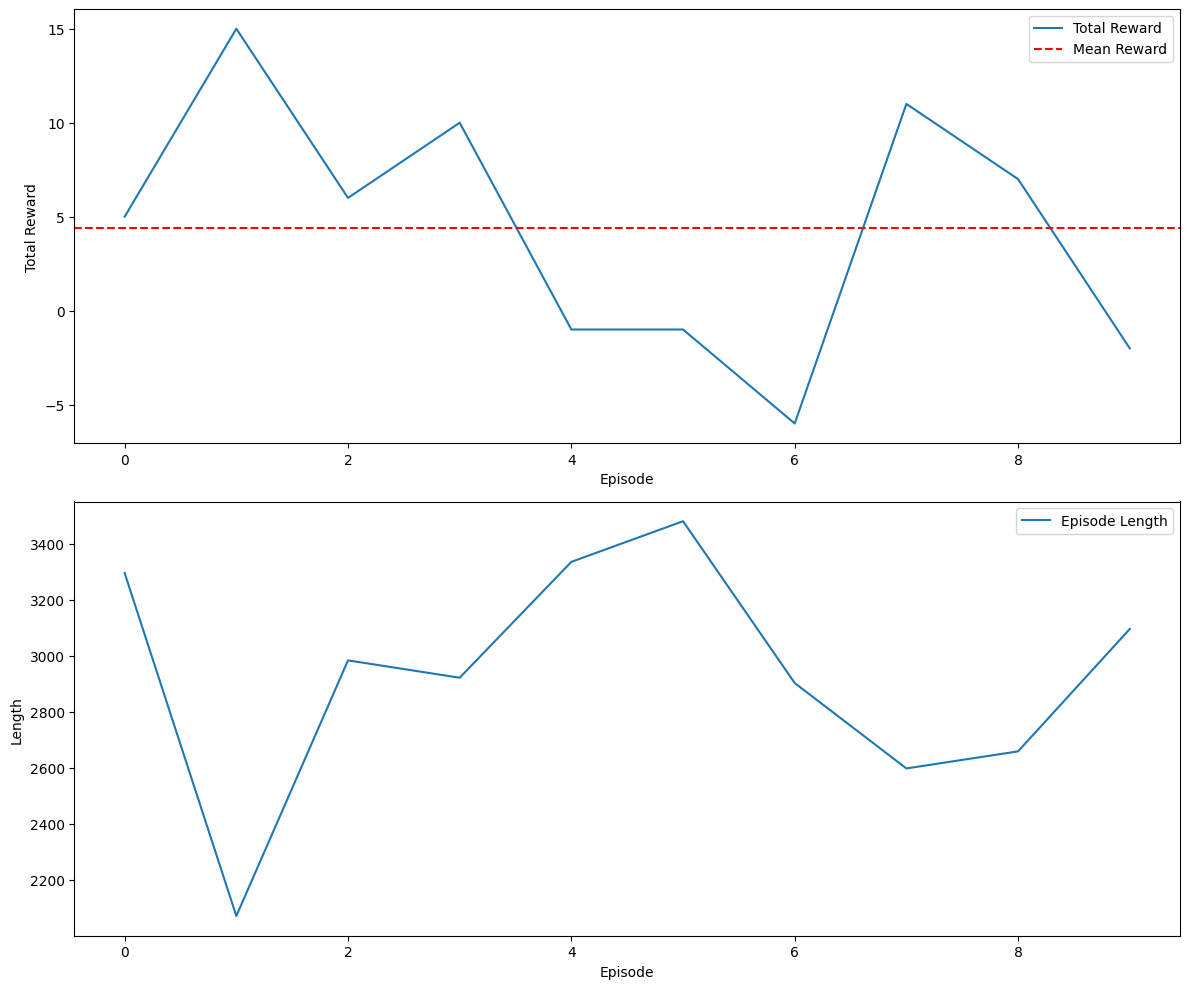

Durchschnittliche Belohnung über 10 Episoden: 4.4


In [26]:
# load model
model = load_model("models/pong_v5_rl_model_episode_900.keras")
# create environment for evaluation
eval_env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
eval_env = gym.wrappers.RecordVideo(
    eval_env, "data/eval_videos", episode_trigger=lambda episode_id: True, video_length=0
)
episode_rewards = []
episode_lengths = []

for episode in range(10):
    total_reward = 0
    step = 0
    state, info = eval_env.reset()
    state = preprocess_state(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    while not done:
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0))
        next_state, reward, done, truncated, info = eval_env.step(action)
        done = done or truncated
        total_reward += reward
        next_state = preprocess_state(next_state)
        next_state = np.append(
            state[:, :, 1:], np.expand_dims(next_state, axis=2), axis=2
        )
        state = next_state
        step += 1
    episode_rewards.append(total_reward)
    episode_lengths.append(step)
    # print results
    print(f"Total Reward: {total_reward}, Steps: {step}")

    # plot results
    if (episode + 1) % 10 == 0:
        plot_eval(
            episode_rewards,
            episode_lengths,
            eval_path="data/plots/eval_plot1.png",
        )

# calculate average reward
avg_reward = np.mean(episode_rewards)

# print average reward
print("Durchschnittliche Belohnung über", "10", "Episoden:", avg_reward)